<a href="https://colab.research.google.com/github/justincheng101/LBNL_Internship/blob/main/XNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Set Hyperparameters

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(2668, 2668, 3)
(2668, 2668)


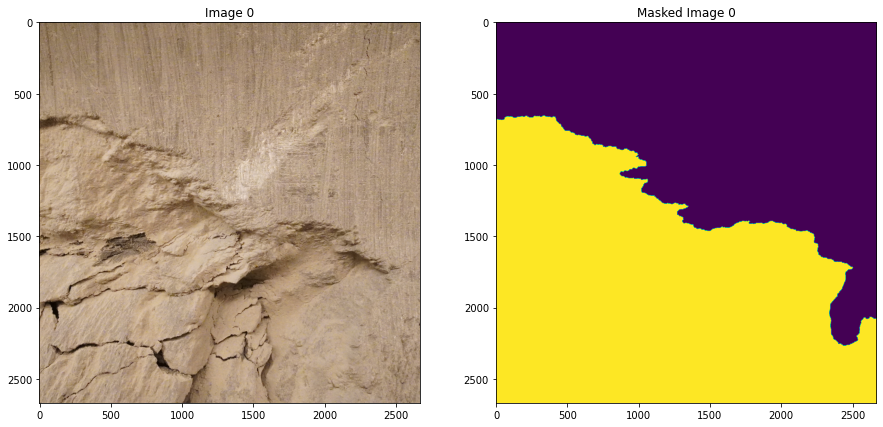

IndexError: ignored

In [2]:
%run './drive/MyDrive/Colab Notebooks/PreprocessSimple.ipynb'

# XNet Model Architecture

In [3]:
def model(input_shape=(64,64,3), classes=3, kernel_size=3, filter_depth=(64,128,256,512,0), dropout_prob=0.3):
    
    img_input = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(img_input)
    batch1 = BatchNormalization()(conv1, training=True)
    act1 = Activation("relu")(batch1)
    drop1 = tf.keras.layers.Dropout(dropout_prob)(act1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    #100x100
    
    conv2 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(pool1)
    batch2 = BatchNormalization()(conv2, training=True)
    act2 = Activation("relu")(batch2)
    drop2 = tf.keras.layers.Dropout(dropout_prob)(act2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    #50x50
    
    conv3 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool2)
    batch3 = BatchNormalization()(conv3, training=True)
    act3 = Activation("relu")(batch3)
    drop3 = tf.keras.layers.Dropout(dropout_prob)(act3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    #25x25
    
    #Flat
    conv4 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool3)
    batch4 = BatchNormalization()(conv4, training=True)
    act4 = Activation("relu")(batch4)
    #drop4 = tf.keras.layers.Dropout(dropout_prob)(act4)
    #25x25
    
    conv5 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act4)
    batch5 = BatchNormalization()(conv5, training=True)
    act5 = Activation("relu")(batch5)
    #drop5 = tf.keras.layers.Dropout(dropout_prob)(act5)
    #25x25
    
    #Up
    up6 = UpSampling2D(size=(2, 2))(act5)
    conv6 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up6)
    batch6 = BatchNormalization()(conv6, training=True)
    act6 = Activation("relu")(batch6)
    concat6 = Concatenate()([act3,act6])
    #50x50
    
    up7 = UpSampling2D(size=(2, 2))(concat6)
    conv7 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up7)
    batch7 = BatchNormalization()(conv7, training=True)
    act7 = Activation("relu")(batch7)
    concat7 = Concatenate()([act2,act7])
    #100x100
    
    #Down
    conv8 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(concat7)
    batch8 = BatchNormalization()(conv8, training=True)
    act8 = Activation("relu")(batch8)
    pool8 = MaxPooling2D(pool_size=(2, 2))(act8)
    #50x50
    
    conv9 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool8)
    batch9 = BatchNormalization()(conv9, training=True)
    act9 = Activation("relu")(batch9)
    pool9 = MaxPooling2D(pool_size=(2, 2))(act9)
    
    #25x25
    
    #Flat
    conv10 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool9)
    batch10 = BatchNormalization()(conv10, training=True)
    act10 = Activation("relu")(batch10)
    #25x25
    
    conv11 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act10)
    batch11 = BatchNormalization()(conv11, training=True)
    act11 = Activation("relu")(batch11)
    #25x25
    
    #Encoder
    up12 = UpSampling2D(size=(2, 2))(act11)
    conv12 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up12)
    batch12 = BatchNormalization()(conv12, training=True)
    act12 = Activation("relu")(batch12)
    concat12 = Concatenate()([act9,act12])
    #50x50
    
    up13 = UpSampling2D(size=(2, 2))(concat12)
    conv13 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up13)
    batch13 = BatchNormalization()(conv13, training=True)
    act13 =  Activation("relu")(batch13)
    concat13 = Concatenate()([act8,act13])
    #100x100
    
    up14 = UpSampling2D(size=(2, 2))(concat13)
    conv14 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(up14)
    batch14 = BatchNormalization()(conv14, training=True)
    act14 = Activation("relu")(batch14)
    concat14 = Concatenate()([act1,act14])
    #200x200
    
    conv15 = Conv2D(classes, (1,1), padding="valid")(concat14)
    
    #reshape15 = Reshape((input_shape[0]*input_shape[1],classes))(conv15)
    #act15 = Activation("softmax")(reshape15)
    
    model = tf.keras.models.Model(img_input, conv15)

    return model

# Train the Model

In [4]:
# Call the helper function for defining the layers for the model, given the input image size
xnet = model(input_shape=(size,size,1), classes=2)

In [5]:
# Check the summary to better interpret how the output dimensions change in each layer
# xnet.summary()

In [6]:
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [7]:
def dice(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [8]:
# This callback stops training when there is no improvement in the monitored
# metric after (patience) epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='auto', restore_best_weights=True)

In [9]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
# Adamax and Nadam seem to perform best
xnet.compile(optimizer=tf.keras.optimizers.Adamax(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = xnet.fit(X_train, y_train, batch_size=16, epochs=40, callbacks=[], validation_data=(X_valid, y_valid))

NameError: ignored

# Inference and Benchmarks (visualization, dice score, IoU, AUC)

In [ ]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy 
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

In [ ]:
xnet.evaluate(X_valid, y_valid)

In [ ]:
# Helper function to get predicted mask
def getPredMask(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = xnet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [ ]:
def IoU(index, smooth=1):
    pred_mask = getPredMask(index)
    y_true = y_valid[index]
    y_true = np.reshape(y_true, (1, size, size, 1)).astype('float32')
    y_pred = np.reshape(pred_mask, (1, size, size, 1)).astype('float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou.numpy()

In [ ]:
def diceScore(index, smooth=1):
    pred_mask = getPredMask(index)
    y_true = y_valid[index]  
    y_true = np.reshape(y_true, (1, size, size, 1)).astype('float32')
    y_pred = np.reshape(pred_mask, (1, size, size, 1)).astype('float32')
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice.numpy()

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
    pred_mask = getPredMask(index)
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    dice_score = diceScore(index)*100
    iou = IoU(index)*100
    plt.xlabel('Dice: ' + str(dice_score) + '%    IoU: ' + str(iou) +'%')
    arr[0].imshow(X_valid[index,:,:,0])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

In [ ]:
for index in range(len(X_valid)):
    VisualizeResults(index)

In [ ]:
y_true = []
y_pred = []

for index in range(len(y_valid)):
    pred = getPredMask(index)  # get prediction for each pixel in the image
    y_true.append(y_valid[index].flatten())  # flatten all targets
    y_pred.append(pred.numpy().flatten())  # flatten all predictions

# concatenate all predictions and targets:
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
# compute the ROC curve
fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
auc_score = metrics.roc_auc_score(y_true, y_pred)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('AUC Score: ' + str(auc_score))
plt.show()